In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax
from jax import config
config.update("jax_enable_x64", True)

import os, sys
sys.path.insert(0, "/home/storage/hans/jax_reco")

In [3]:
from lib.sim_data_i3 import I3SimHandlerFtr
from lib.network import TriplePandleNet
from lib.plotting_tools import plot_event
from time_sampler import sample_times

2024-05-20 17:14:47.785044: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandlerFtr(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

In [5]:
event_index = 2
meta, pulses = sim_handler.get_event_data(event_index)
print(meta['muon_energy_at_detector'])

event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

4719.856364512047


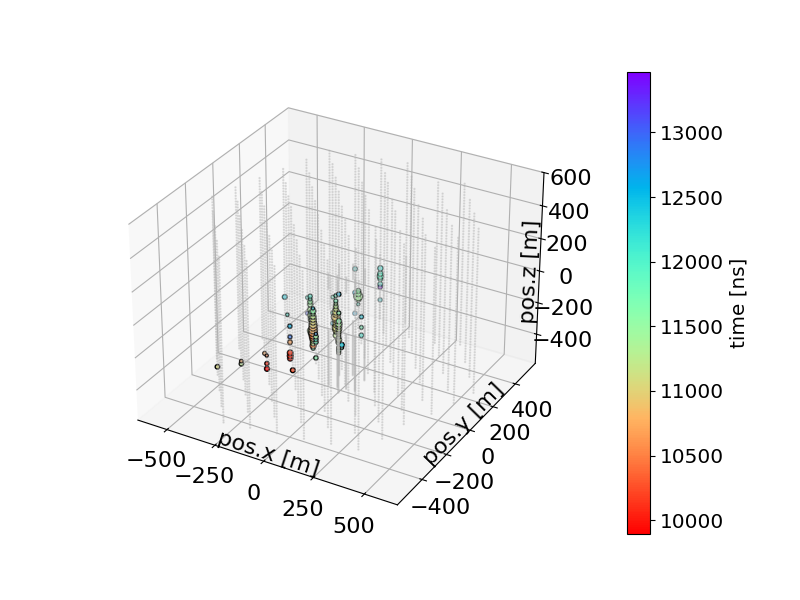

In [8]:
plot_event(event_data, geo=sim_handler.geo)

In [9]:
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

network = TriplePandleNet('../../data/network/')

In [10]:
key = jax.random.PRNGKey(2)

In [11]:
key, subkey = jax.random.split(key)
first_times = sample_times(event_data, track_pos, track_src, track_time, network, subkey)

(16, 102)


(9500.0, 13500.0)

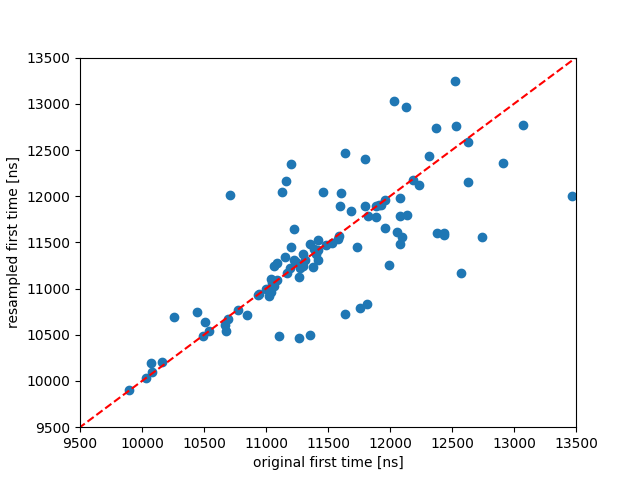

In [12]:
plt.figure()
plt.scatter(event_data['time'], first_times)
plt.xlabel("original first time [ns]")
plt.ylabel("resampled first time [ns]")
plt.plot([0, 100000], [0, 100000], "r--")
plt.xlim([9500, 13500])
plt.ylim([9500, 13500])

In [13]:
%timeit sample_times(event_data, track_pos, track_src, track_time, network, subkey)

(16, 102)
(16, 102)
(16, 102)
(16, 102)
(16, 102)
(16, 102)
(16, 102)
(16, 102)
692 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
from lib.geo import cherenkov_cylinder_coordinates_v
from lib.geo import get_xyz_from_zenith_azimuth

track_dir_xyz = get_xyz_from_zenith_azimuth(track_src)
geo_time, closest_dist, _ = cherenkov_cylinder_coordinates_v(event_data[['x', 'y', 'z']].to_numpy(), track_pos, track_dir_xyz)

(0.0, 300.0)

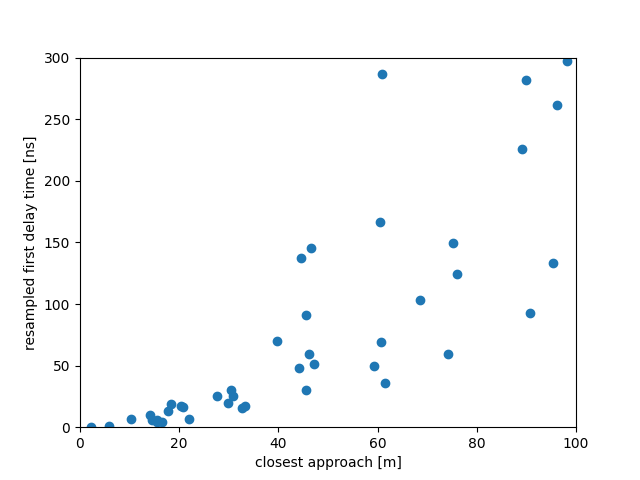

In [29]:
plt.figure()
plt.scatter(closest_dist, first_times-geo_time-meta['muon_time'])
plt.xlabel("closest approach [m]")
plt.ylabel("resampled first delay time [ns]")
plt.xlim([0, 100])
plt.ylim([0, 300])